In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
from q_value_calc_crosslinks import calcQ
import matplotlib.pyplot as plt
from functions import get_target_id, get_datasets, rerank, get_top_indices, get_last_top_indices, get_nth_top_scan
import re
import os
from matplotlib.pyplot import text

Set parameters for pipeline: 
- i: dataset to use (1: HeLa, 2: E.Coli.1, 3: E.Coli.2, 4:E.Coli.3(, 5:top-down data, not used))
- pep_filter: whether to filter unique peptides (True/False)
- decoy: how to select negative examples for approach accounting for spectral bias (bottom: bottom 250, second: second-rank PSM, last: last-rank PSM, bottom+second: bottom 250 and second-rank PSM, bottom+last: bottom 250 and last-rank PSM)
- mixture-model: whether use mixture model for selection (None: no mixture model for selection, mm_std: standard-deviation based threshold, FDR5%: threshold at 5% FDR, FDR1%: threshold at 1% FDR)
- bottom_fdr: whether to apply the FDR threshold also to the negative class (True/False) - only relevant if mixture-model != None
- class-threshold: maximal number of traning datapoints per class (always set to 500)

In [24]:
i = 4
n_iters = 5
pep_filter = False
#decoy = "second" 
decoy = "bottom" 
#decoy = "last" 
#decoy = "bottom+last"
#decoy = "bottom+second"
mixture_model = None
#mixture_model = "FDR5%"
#mixture_model = "FDR1%"
#mixture_model = "mm_std"
bottom_fdr = False
class_threshold = 500


In [25]:
# load data
dataset = get_datasets()
input_filename = f"{dataset[i]['file']}.pkl"
input_file = f"../data/{dataset[i]['type']}/{dataset[i]['name']}/{input_filename}" 
# read original dataframes
original_df = pd.read_pickle(input_file)

In [26]:
# define features
if dataset[i]['type'] == 'crosslink_data':

    features = ['Score','peplen', 'NuXL:isXL', 'NuXL:modds', 'NuXL:pl_modds', 
                    'NuXL:mass_error_p', 'NuXL:tag_XLed', 'NuXL:tag_unshifted' ,
                    'NuXL:tag_shifted', 'missed_cleavages', 'NuXL:ladder_score',
                    'variable_modifications']
elif dataset[i]['type'] == 'top_down_data':
    features = ['Score', 'NumMass', 'MatchingFragments', 'Coverage(%)', 'TagCount', 'ModCount', 'PrecursorQscore']

# filter data and sort according to descending score
original_df = original_df.filter(np.concatenate([features,['ScanNr', 'rank', 'Label', 'PSMId', 'Peptide','class-specific_q-val', 'cum_target_id']]))
original_df.sort_values('Score',ascending=False, inplace=True)


Truncating to 500

Fitting 5 folds for each of 7 candidates, totalling 35 fits


c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[labelColName].replace(to_replace=-1, value=0, inplace=True)


Truncating to 500

Fitting 5 folds for each of 7 candidates, totalling 35 fits


c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[labelColName].replace(to_replace=-1, value=0, inplace=True)


Truncating to 500

Fitting 5 folds for each of 7 candidates, totalling 35 fits


c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[labelColName].replace(to_replace=-1, value=0, inplace=True)


Truncating to 500

Fitting 5 folds for each of 7 candidates, totalling 35 fits


c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[labelColName].replace(to_replace=-1, value=0, inplace=True)


Truncating to 500

Fitting 5 folds for each of 7 candidates, totalling 35 fits


c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[labelColName].replace(to_replace=-1, value=0, inplace=True)


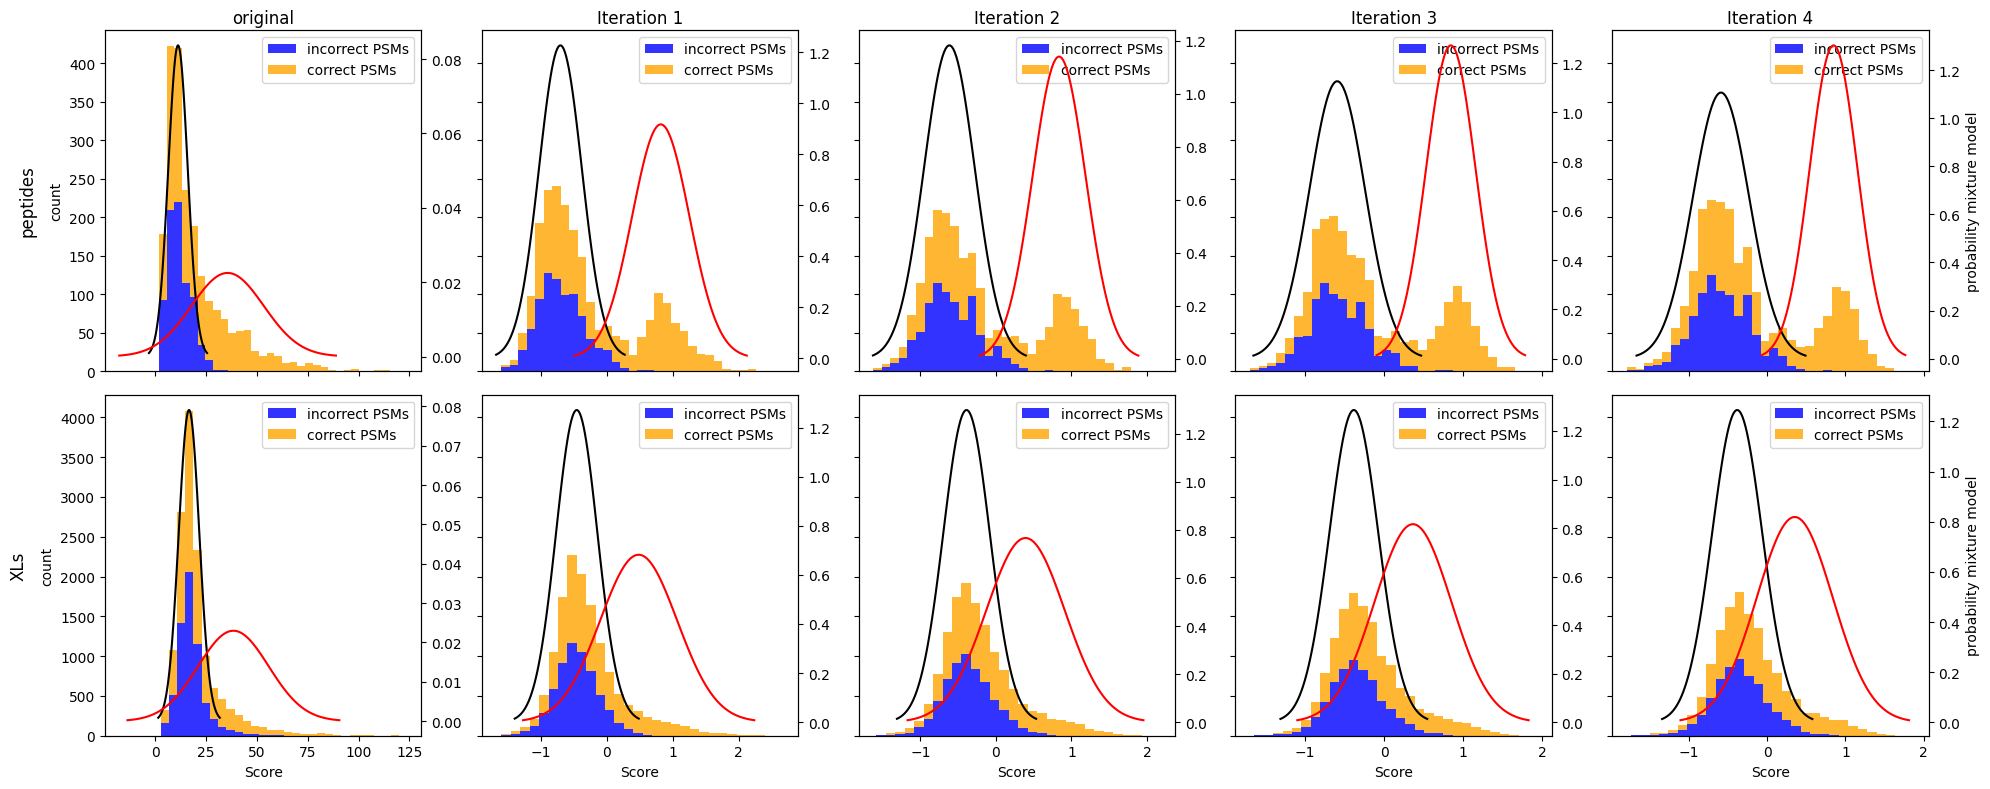

In [27]:
 # initialise the k-fold cross validator
no_split = 5
kf = KFold(n_splits=no_split, shuffle=True, random_state=1)

param_grid = {
        'svc__C': np.power(float(2), [-5,-1,1,5,7,11,15]),
        #'svc__class_weight': [{1:0.3,0:0.7},{1:0.4,0:0.6},{1:0.5,0:0.5}]
    }

pipe = make_pipeline(MinMaxScaler(), SVC(kernel='linear'))
# create the pipeline
gs = GridSearchCV(pipe,
                param_grid=param_grid, 
                n_jobs=-1,
                scoring="accuracy",
                cv=kf, 
                refit=True,
                verbose = 2)
# filter dataframes
filter_col = 'PSMId'
filter_val = 1

train_idx_list_bottom = []
train_idx_list_top = []
class_weights = []
original_df[f'Score_no_svm'] = original_df['Score']
original_df[f"PSMId_no_svm"] = original_df['PSMId']
original_df[f"class-specific_q-val_no_svm"] = original_df['class-specific_q-val']
original_df[f"cum_target_id_no_svm"] = original_df['cum_target_id']

fig, axes = plt.subplots(2,n_iters, sharex='col', sharey='row', figsize=(20, 8))
axs2 = []

for iteration in range(1,n_iters + 1):    
   # sort dataframe according to Score column
    original_df.sort_values('Score',ascending=False, inplace=True)
    # filter first-rank PSMs
    if dataset[i]['type'] == 'crosslink_data':
        if pep_filter:
            peptides_top_indices = get_nth_top_scan(original_df ,n=0,group_col= "Peptide", score_col="Score").index
            psm_top_indices = get_nth_top_scan(original_df, n=0,group_col= "ScanNr", score_col= "Score").index
            top_indices = peptides_top_indices.intersection(psm_top_indices)
        else:
            top_indices = get_nth_top_scan(original_df, n= 0, group_col="ScanNr", score_col="Score").index
    elif dataset[i]['type'] == 'top_down_data':
        top_indices = get_nth_top_scan(original_df, n= 0, group_col="ScanNr", score_col="Score").index
    # determine minority class 
    classes = []
    for c in np.unique(original_df[dataset[i]['group']]):
        group_indices = original_df.loc[(original_df[dataset[i]['group']] == c),:].index
        filtered_indices = top_indices.intersection(group_indices)
        classes.append(len(original_df.loc[filtered_indices,:]))
    minority_class = min(classes)
    
    if (minority_class > class_threshold):
        print("Truncating to " + str(class_threshold) + "\n") 
        minority_class = class_threshold

    # define training data (top and bottom scores of each class with PSMId = 1)
    train_idx = []
    train_idx_list_bottom_iter = []
    train_idx_list_top_iter = []
    original_df['train_label'] = np.NaN
    original_df.sort_values('Score',ascending=False, inplace=True)
    
    ax1 = axes[:,iteration-1]
    # iterate over classes
    for c in np.unique(original_df[dataset[i]['group']]):
        # filter datapoints of current class
        group_indices = original_df.loc[(original_df[dataset[i]['group']] == c),:].index
        filtered_indices = top_indices.intersection(group_indices)

        # plot first-rank PSM score distribution as histogram colored by label
        labels = original_df.loc[filtered_indices, "Label"].values
        color = np.repeat("orange", len(labels))
        color[labels == 0] = "blue"
        idx_decoy = original_df.loc[filtered_indices,:][original_df.loc[filtered_indices, "Label"] == 0].index
        idx_target = original_df.loc[filtered_indices,:][original_df.loc[filtered_indices, "Label"] == 1].index
        ax1[c].hist([original_df.loc[idx_decoy, "Score"].values,original_df.loc[idx_target, "Score"].values], bins=30, color = ["blue", "orange"], alpha = 0.8, histtype='bar', stacked=True, label = ["incorrect PSMs", "correct PSMs"])
        ax1[c].legend()

        # fit a gaussian mixture model
        model = GaussianMixture(n_components=2,covariance_type='full', random_state=1)
        model.fit(original_df.loc[filtered_indices, "Score"].values.reshape(-1, 1))
        
        # determine which component is the decoy and target distribution
        means = model.means_.flatten()
        cov = model.covariances_.flatten()
        sigma = np.sqrt(cov)

        # plot mixture model
        import scipy.stats as stats
        x1 = np.linspace(means[np.argmin(means)] - 3*sigma[np.argmin(means)], means[np.argmin(means)] + 3*sigma[np.argmin(means)], 100)
        x2 = np.linspace(means[np.argmax(means)] - 3*sigma[np.argmax(means)], means[np.argmax(means)] + 3*sigma[np.argmax(means)], 100)
        plt.figure(1)
        ax2 = ax1[c].twinx()
        decoy_dist = stats.norm.pdf(x1, means[np.argmin(means)], sigma[np.argmin(means)])
        target_dist = stats.norm.pdf(x2, means[np.argmax(means)], sigma[np.argmax(means)])
        ax2.plot(x1, decoy_dist, color = "black")
        ax2.plot(x2, target_dist, color = "red")
        axs2.append(ax2)

        # define training datapoints without mixture model
        if mixture_model == None:
            # define positive training datapoints as top 250
            class_top = original_df.loc[filtered_indices,:].sort_values('Score',ascending=False)[:int(minority_class/2)].index
            threshold_top = np.min(original_df.loc[class_top, "Score"])
            # define negative training datapoints with different methods
            if decoy == "bottom": # bottom 250
                class_bottom = original_df.loc[filtered_indices,:].sort_values('Score',ascending=False)[-int(minority_class/2):].index
            elif decoy == "last": # last PSM of each target
                top_scans = original_df.loc[class_top,'ScanNr']
                last_decoys = get_nth_top_scan(original_df.loc[original_df['ScanNr'].isin(top_scans),:],n=-1, group_col="ScanNr", score_col="Score").index
                last_decoys = last_decoys.difference(class_top)
                class_bottom = last_decoys
            elif decoy == "second": # second PSM of each target
                top_scans = original_df.loc[class_top,'ScanNr']
                second_decoys = get_nth_top_scan(original_df.loc[original_df['ScanNr'].isin(top_scans),:],n= 1, group_col="ScanNr", score_col="Score").index
                class_bottom = second_decoys
            elif decoy == "bottom+last": # bottoms and last of each target
                class_bottom = original_df.loc[filtered_indices,:].sort_values('Score',ascending=False)[-int(minority_class/2):].index
                top_scans = original_df.loc[class_top,'ScanNr']
                last_decoys = get_nth_top_scan(original_df.loc[original_df['ScanNr'].isin(top_scans),:],n=-1, group_col="ScanNr", score_col="Score").index
                last_decoys = last_decoys.difference(class_top)
                class_bottom = np.concatenate([class_bottom, last_decoys])
            elif decoy == "bottom+second": # bottom and second of each target
                class_bottom = original_df.loc[filtered_indices,:].sort_values('Score',ascending=False)[-int(minority_class/2):].index
                top_scans = original_df.loc[class_top,'ScanNr']
                second_decoys = get_nth_top_scan(original_df.loc[original_df['ScanNr'].isin(top_scans),:],n=1,group_col="ScanNr", score_col="Score").index
                class_bottom = np.concatenate([class_bottom, second_decoys])
            threshold_bottom = np.max(original_df.loc[class_bottom, "Score"])
        # define training datapoints with mixture model
        else: 
            if mixture_model == "mm_std": # standard-deviation based approach
                class_top = []
                class_bottom = []
                factor_bottom = 2.5
                factor_top = 2.5
                class_bottom_defined = False
                class_top_defined = False
                # negative training datapoints: mean - factor_bottom * std
                while(len(class_bottom) < 50):
                    class_bottom = original_df.loc[filtered_indices,:][original_df.loc[filtered_indices,"Score"] <= means[np.argmin(means)] - factor_bottom*sigma[np.argmin(means)]].index
                    factor_bottom -= 0.25
                # positive training datapoints: mean - factor_top * std
                while(len(class_top) < 50):
                    class_top = original_df.loc[filtered_indices,:][original_df.loc[filtered_indices,"Score"] >= means[np.argmax(means)] + factor_top*sigma[np.argmax(means)]].index
                    factor_top -= 0.25
                threshold_bottom = means[np.argmin(means)] - factor_bottom*sigma[np.argmin(means)]
                threshold_top = means[np.argmax(means)] + factor_top*sigma[np.argmax(means)]
                print(f"top: p={factor_top}, len={len(class_top)}\nbottom p={factor_bottom}, len={len(class_bottom)}")
            elif mixture_model == "FDR1%": # FDR based approach at 1%
                # positive training datapoints
                scores_desc = original_df.loc[filtered_indices,"Score"].sort_values(ascending=False).values # sort scores
                decoy_probs = stats.norm.pdf(scores_desc, means[np.argmin(means)], sigma[np.argmin(means)]) # compute probabilities for negative class
                target_probs = stats.norm.pdf(scores_desc, means[np.argmax(means)], sigma[np.argmax(means)]) # compute probabilities for positive class
                pep_top = decoy_probs/(decoy_probs + target_probs) # posterior-error probability
                fdr_top = np.cumsum(pep_top)/np.arange(1,len(pep_top) + 1) # FDR

                arg_threshold_top = np.argwhere(fdr_top > 0.01)[0]
                threshold_top = scores_desc[arg_threshold_top][0]
                class_top = original_df.loc[filtered_indices,:][original_df.loc[filtered_indices,"Score"] > threshold_top ].index
                

                # negative training datapoints
                scores_asc = original_df.loc[filtered_indices,"Score"].sort_values(ascending=True).values
                decoy_probs = stats.norm.pdf(scores_asc, means[np.argmin(means)], sigma[np.argmin(means)])
                target_probs = stats.norm.pdf(scores_asc, means[np.argmax(means)], sigma[np.argmax(means)])
                pep_bottom = target_probs/(decoy_probs + target_probs)
                fdr_bottom = np.cumsum(pep_bottom)/np.arange(1,len(pep_bottom) + 1)
                
                # check whether negative training datapoints should also be computed with FDR
                if bottom_fdr:
                    # does the FDR even reach the FRD threshold?
                    if min(fdr_bottom) < 0.01:
                        arg_threshold_bottom = np.argwhere(fdr_bottom < 0.01)[-1]
                        threshold_bottom = scores_asc[arg_threshold_bottom][0]
                        class_bottom = original_df.loc[filtered_indices,:][original_df.loc[filtered_indices,"Score"] < threshold_bottom ].index
                    # if not just use bottom 250 as negative training datapoints
                    else:
                        class_bottom = original_df.loc[filtered_indices,:].sort_values('Score',ascending=False)[-int(minority_class/2):].index
                        threshold_bottom = np.max(original_df.loc[class_bottom, "Score"])
                # otherwise use bottom 250 as negative training datapoints
                else:
                    class_bottom = original_df.loc[filtered_indices,:].sort_values('Score',ascending=False)[-int(minority_class/2):].index
                    threshold_bottom = np.max(original_df.loc[class_bottom, "Score"])
                
                plt.close(fig)
                # plot for PEP and FDR
                '''plt.figure(2)
                fig2, ax = plt.subplots(1, sharex=True)
                ax1[c].legend()
                ax.plot(scores_desc, pep_top, label="PEP (top)")
                ax.plot(scores_desc, fdr_top, label="FDR (top)")
                ax.plot(scores_asc, pep_bottom, label="PEP (bottom)")
                ax.plot(scores_asc, fdr_bottom, label="FDR (bottom)")
                ax.vlines([threshold_top, threshold_bottom], 0,1)
                ax.set_ylim(0,1)
                ax.set_xlabel("Scores")
                ax.legend()
                plt.show()'''

            elif mixture_model == "FDR5%": # only difference here is that FDR is at 5%
                # positive training datapoint selection
                scores_desc = original_df.loc[filtered_indices,"Score"].sort_values(ascending=False).values
                decoy_probs = stats.norm.pdf(scores_desc, means[np.argmin(means)], sigma[np.argmin(means)])
                target_probs = stats.norm.pdf(scores_desc, means[np.argmax(means)], sigma[np.argmax(means)])
                pep_top = decoy_probs/(decoy_probs + target_probs)
                fdr_top = np.cumsum(pep_top)/np.arange(1,len(pep_top) + 1)
                arg_threshold_top = np.argwhere(fdr_top > 0.05)[0]
                threshold_top = scores_desc[arg_threshold_top][0]
                class_top = original_df.loc[filtered_indices,:][original_df.loc[filtered_indices,"Score"] > threshold_top ].index
                
                # negative training datapoint selection
                scores_asc = original_df.loc[filtered_indices,"Score"].sort_values(ascending=True).values
                decoy_probs = stats.norm.pdf(scores_asc, means[np.argmin(means)], sigma[np.argmin(means)])
                target_probs = stats.norm.pdf(scores_asc, means[np.argmax(means)], sigma[np.argmax(means)])
                pep_bottom = target_probs/(decoy_probs + target_probs)
                fdr_bottom = np.cumsum(pep_bottom)/np.arange(1,len(pep_bottom) + 1)
                
                if bottom_fdr:
                    if min(fdr_bottom) < 0.05:
                        arg_threshold_bottom = np.argwhere(fdr_bottom < 0.05)[-1]
                        threshold_bottom = scores_asc[arg_threshold_bottom][0]
                        class_bottom = original_df.loc[filtered_indices,:][original_df.loc[filtered_indices,"Score"] < threshold_bottom ].index
                    else:
                        class_bottom = original_df.loc[filtered_indices,:].sort_values('Score',ascending=False)[-int(minority_class/2):].index
                        threshold_bottom = np.max(original_df.loc[class_bottom, "Score"])
                else:
                    class_bottom = original_df.loc[filtered_indices,:].sort_values('Score',ascending=False)[-int(minority_class/2):].index
                    threshold_bottom = np.max(original_df.loc[class_bottom, "Score"])

        # set training labels                 
        original_df.loc[class_top,'train_label'] = 1
        original_df.loc[class_bottom,'train_label'] = 0

        # save indices of training datapoints in list
        train_idx = np.concatenate([train_idx, class_top, class_bottom])
        train_idx_list_bottom_iter = np.concatenate([train_idx_list_bottom_iter, class_bottom])
        train_idx_list_top_iter = np.concatenate([train_idx_list_top_iter, class_top])

    plt.figure(fig)
    fig.tight_layout()
    
    train_idx_list_bottom.append(train_idx_list_bottom_iter) 
    train_idx_list_top.append(train_idx_list_top_iter)
    
    # fit SVM
    gs.fit(original_df.loc[train_idx, features], original_df.loc[train_idx, 'train_label'])
    class_weights.append(gs.best_params_)
    
    # compute new score
    original_df['Score'] = gs.decision_function(original_df.loc[:,features])
    original_df[f'Score_{iteration}'] = original_df['Score']

    # rerank PSMs
    if dataset[i]['type'] != 'top_down_data':
        original_df = rerank(original_df, "ScanNr", "Score", "PSMId")
    original_df[f"PSMId_{iteration}"] = original_df['PSMId']

    # filter for rank = 0
    mask = original_df[original_df[filter_col] == filter_val].index
    
    # compute q-values
    original_df.loc[mask,:] = calcQ(original_df.loc[mask,:], classColName=dataset[i]['group'])
    original_df.loc[mask,f"class-specific_q-val_{iteration}"] = original_df.loc[mask,'class-specific_q-val']
    
    # compute target IDs
    original_df.loc[mask,:] = get_target_id(original_df.loc[mask,:], isXLColName=dataset[i]['group'])
    original_df.loc[mask,f"cum_target_id_{iteration}"] = original_df.loc[mask,'cum_target_id']

# plot evolution of first-rank PSM scores
cols = ['Iteration {}'.format(col) for col in range(0, n_iters + 1)]
cols[0] = 'original'
pad = 5
rows = ["peptides", "XLs"]
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)
for k,ax in enumerate(axs2):
    if k >= len(axs2) - 2:
        ax.set_ylabel("probability mixture model")
for ax, col in zip(axes[1], cols):
    ax.set_xlabel(f"Score")
for ax, col in zip(axes[:,0], rows):
    ax.set_ylabel(f"count")
plt.tight_layout()
output_path = f"../results/{dataset[i]['type']}/{dataset[i]['name']}/{class_threshold}/"
if mixture_model != None:
    output_name = mixture_model
    if bottom_fdr:
        output_name += " incl. bottom"
else: 
    output_name = decoy
plt.savefig(output_path + f"score_distribution_{output_name}.png")
plt.show()

In [28]:
# save entire dataframe
directory=f"../data/{dataset[i]['type']}/{dataset[i]['name']}/{class_threshold}/"
if pep_filter and dataset[i]['type'] == 'crosslink_data':
    directory += "pep_unique/"
elif mixture_model != None:
    directory += "mixture_model/"
    if mixture_model == "prob":
        directory += f"prob/"
    elif mixture_model == "FDR5%":
        directory += f"FDR5%/"
        if bottom_fdr:
            directory += "bottom_fdr/"
    elif mixture_model == "FDR1%":
        directory += f"FDR1%/"
        if bottom_fdr:
            directory += "bottom_fdr/"

else:
    directory += "default/"
if decoy != 'bottom':
    directory += f"decoy_{decoy}/"
if not os.path.exists(directory):
    os.makedirs(directory)
output_file = re.sub('.pkl', f"_svm.pkl", input_filename)
path = directory + output_file

output_cols = [ 'NuXL:isXL','Label',
                    'Score_no_svm', 'PSMId_no_svm', 'class-specific_q-val_no_svm', 'cum_target_id_no_svm']
for iter in range(1, n_iters+1):
    output_cols.append(f'Score_{iter}')
    output_cols.append(f'PSMId_{iter}')
    output_cols.append(f'class-specific_q-val_{iter}')
    output_cols.append(f'cum_target_id_{iter}')
original_df.loc[:,output_cols].to_pickle(path)
# display new dataframe
display(original_df.loc[:,output_cols])

,NuXL:isXL,Label,Score_no_svm,PSMId_no_svm,class-specific_q-val_no_svm,cum_target_id_no_svm,Score_1,PSMId_1,class-specific_q-val_1,cum_target_id_1,...,class-specific_q-val_3,cum_target_id_3,Score_4,PSMId_4,class-specific_q-val_4,cum_target_id_4,Score_5,PSMId_5,class-specific_q-val_5,cum_target_id_5
0,0,0,7.697114,1,0.560510,1099.0,-0.464042,1,0.272956,795.0,...,0.216802,738.0,-0.222111,1,0.203830,731.0,-0.178335,1,0.195021,723.0
1,1,1,12.917113,1,0.744821,6662.0,0.032731,1,0.203294,2307.0,...,0.149449,1907.0,0.274106,1,0.144872,1843.0,0.266139,1,0.149464,1773.0
2,1,1,12.854518,2,NaN,NaN,-0.024380,2,NaN,NaN,...,NaN,NaN,0.225149,2,NaN,NaN,0.223359,2,NaN,NaN
3,1,0,8.609119,3,NaN,NaN,-0.429284,3,NaN,NaN,...,NaN,NaN,-0.154728,3,NaN,NaN,-0.143224,3,NaN,NaN
4,1,0,8.548115,4,NaN,NaN,-0.486374,4,NaN,NaN,...,NaN,NaN,-0.203684,4,NaN,NaN,-0.186003,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87046,1,0,2.910212,2,NaN,NaN,-1.224790,1,0.783278,7798.0,...,0.787048,7767.0,-1.131725,1,0.787251,7671.0,-1.156139,1,0.792851,7526.0
87045,1,0,2.930583,1,0.781246,7881.0,-1.490889,2,NaN,NaN,...,NaN,NaN,-1.640662,2,NaN,NaN,-1.766014,2,NaN,NaN
87047,1,1,7.778641,1,0.774333,7644.0,-1.520285,1,0.783915,7821.0,...,0.787855,7806.0,-1.646070,1,0.788322,7724.0,-1.754574,1,0.793990,7587.0
87048,1,0,3.782600,1,0.780559,7870.0,-1.189337,1,0.783278,7798.0,...,0.786706,7703.0,-1.064039,1,0.786803,7608.0,-1.086671,1,0.791449,7461.0


In [29]:
# compute occurances of most common peptides in the training data in each iteration
df_top_counts = []
df_bottom_counts = []

for i in range(0,5):
    top_counts = original_df.loc[train_idx_list_top[i],"Peptide"].value_counts()
    bottom_counts = original_df.loc[train_idx_list_bottom[i],"Peptide"].value_counts()
    df_top_counts.append(top_counts[:10].values/np.sum(top_counts))
    df_bottom_counts.append(bottom_counts[:10].values/np.sum(bottom_counts))
df_top_counts = pd.DataFrame(np.array(df_top_counts).T, columns = range(1,6))
df_bottom_counts = pd.DataFrame(np.array(df_bottom_counts).T, columns = range(1,6))
# save this in two dataframes
if decoy == 'bottom':
    df_top_counts.to_pickle(directory + "top_counts_baseline.pkl")
    df_bottom_counts.to_pickle(directory + "bottom_counts_baseline.pkl")